<a href="https://colab.research.google.com/github/SpandanJogannagari/Machine-Learning-Homeworks/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619398 sha256=791bd82e3ef44a0b66ff81ebcdd537de426b3b0c2ba6109e9743e036cfd60533
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise import KNNBasic
from surprise import NMF
from surprise import NormalPredictor

from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise.model_selection import KFold, cross_validate

import warnings; warnings.simplefilter('ignore')
from surprise.model_selection import GridSearchCV
from collections import defaultdict
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
credits_df=pd.read_csv('/content/drive/MyDrive/ML_Project/credits.csv')
keywords_df=pd.read_csv('/content/drive/MyDrive/ML_Project/keywords.csv')
links_df=pd.read_csv('/content/drive/MyDrive/ML_Project/links.csv')
MovieData_df=pd.read_csv('/content/drive/MyDrive/ML_Project/movies_metadata.csv')
Ratings_df=pd.read_csv('/content/drive/MyDrive/ML_Project/ratings.csv')

In [ ]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
Ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
MovieData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
MovieData_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Removing Unecessary columns

In [ ]:
MovieData_df.drop(['homepage','video'],1)

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,3.8,6.0
45464,False,NaN,0,[],227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg,"[{'name': 'Yermoliev'

In [ ]:
def convert_int(x):
  try:
    return int(x)
  except:
    return np.nan

In [ ]:
MovieData_df['id']=MovieData_df['id'].apply(convert_int)
keywords_df['id']=keywords_df['id'].apply(convert_int)
credits_df['id']=credits_df['id'].apply(convert_int)


Checking if we have any null data

In [ ]:
def check_missing(data_df):
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

check_missing(Ratings_df)

,timestamp,rating,movieId,userId
Total,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0


In [ ]:
check_missing(credits_df)

,id,crew,cast
Total,0.0,0.0,0.0
Percent,0.0,0.0,0.0


In [ ]:
check_missing(keywords_df)

,keywords,id
Total,0.0,0.0
Percent,0.0,0.0


In [ ]:
check_missing(links_df)

,tmdbId,imdbId,movieId
Total,8.000000,0.0,0.0
Percent,0.082119,0.0,0.0


In [ ]:
check_missing(MovieData_df)

,belongs_to_collection,homepage,tagline,overview,poster_path,runtime,status,release_date,imdb_id,original_language,vote_average,vote_count,revenue,spoken_languages,title,video,popularity,production_companies,production_countries,id,original_title,genres,budget,adult
Total,40972.000000,37684.000000,25054.000000,954.000000,386.000000,263.000000,87.000000,87.000000,17.000000,11.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0
Percent,90.115691,82.883913,55.104914,2.098271,0.848986,0.578454,0.191352,0.191352,0.037391,0.024194,0.013197,0.013197,0.013197,0.013197,0.013197,0.013197,0.010997,0.006598,0.006598,0.006598,0.0,0.0,0.0,0.0


In [ ]:
MovieData_df.dropna(subset=['title'], inplace=True)
check_missing(MovieData_df)

,belongs_to_collection,homepage,tagline,overview,poster_path,runtime,release_date,status,imdb_id,original_language,budget,genres,id,original_title,vote_count,popularity,vote_average,production_companies,production_countries,revenue,spoken_languages,title,video,adult
Total,40970.000000,37682.000000,25048.000000,954.000000,383.000000,257.000000,84.000000,81.000000,17.000000,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,90.123185,82.890453,55.098988,2.098548,0.842499,0.565332,0.184778,0.178179,0.037396,0.024197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Adding Year column to the data

In [ ]:
MovieData_df['year'] = pd.to_datetime(MovieData_df['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
MovieData_df.drop(['release_date'],1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050.0,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109.0,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758.0,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,NaN,0,[],NaN,227506.0,tt000853

In [ ]:
MovieData_df[MovieData_df['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year


Demographic Filtering

In [ ]:

MovieData_df['genres'] = MovieData_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i[
    'name'] for i in x] if isinstance(x, list) else [])

In [ ]:
v_Count=MovieData_df[MovieData_df['vote_count'].notnull()]['vote_count'].astype('int')
v_Avg =MovieData_df[MovieData_df['vote_average'].notnull()]['vote_average'].astype('int')
M_Vote=v_Avg.mean()
M_Vote

5.244896612406511

In [ ]:
Min_Vote=v_Count.quantile(0.95)
Min_Vote

434.0

In [ ]:
qualified = MovieData_df[(MovieData_df['vote_count'] >= Min_Vote) & 
               (MovieData_df['vote_count'].notnull()) & 
               (MovieData_df['vote_average'].notnull())][['title', 
                                                'year', 
                                                'vote_count', 
                                                'vote_average', 
                                                'popularity', 
                                                'genres']]

qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+Min_Vote) * R) + (Min_Vote/(Min_Vote+v) * M_Vote)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)


In [ ]:
qualified = qualified.sort_values('wr', ascending=False).head(250)


In [ ]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


Filtering based on genre

In [ ]:
s = MovieData_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
mov_genres = MovieData_df.drop('genres', axis=1).join(s)
mov_genres.head().transpose()

,0,0,0,1,1
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,NaN
budget,30000000,30000000,30000000,65000000,65000000
homepage,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,NaN,NaN
id,862,862,862,8844,8844
imdb_id,tt0114709,tt0114709,tt0114709,tt0113497,tt0113497
original_language,en,en,en,en,en
original_title,Toy Story,Toy Story,Toy Story,Jumanji,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,When siblings Judy and Peter discover an encha...
popularity,21.9469,21.9469,21.9469,17.0155,17.0155


In [ ]:
def build_chart(genre, percentile=0.85):
    df = mov_genres[mov_genres['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: 
                        (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C),
                        axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [ ]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.565285
351,Forrest Gump,1994,8147,8,48.3072,7.971357
876,Vertigo,1958,1162,8,18.2082,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.8451,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,7.744878
19901,Paperman,2012,734,8,7.19863,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.9943,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [ ]:
links_df = links_df[links_df['tmdbId'].notnull()]['tmdbId'].astype('int')


In [ ]:
MovieData_df['id'] = MovieData_df['id'].apply(convert_int)


In [ ]:
MovieData_df['id'] = MovieData_df['id'].astype('int')

In [ ]:
smd = MovieData_df[MovieData_df['id'].isin(links_df)]
smd.shape

(9553, 25)

**Content based recommendation system : Using movie description and taglines**

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
tfidf_matrix.shape


(9553, 276438)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim1 = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])
indices.head(2)

title
Toy Story    0
Jumanji      1
dtype: int64

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations("Toy Story").head(10)

2352               Toy Story 2
7336               Toy Story 3
5958    The 40 Year Old Virgin
2389           Man on the Moon
6405              Factory Girl
4452    What's Up, Tiger Lily?
839      Rebel Without a Cause
6327    For Your Consideration
4760          Rivers and Tides
9172      Welcome to Happiness
Name: title, dtype: object

In [ ]:
get_recommendations('The Dark Knight').head(10)



7745                      The Dark Knight Rises
126                              Batman Forever
1058                             Batman Returns
7361                 Batman: Under the Red Hood
509                                      Batman
8056    Batman: The Dark Knight Returns, Part 2
9412                      The Lego Batman Movie
7710                           Batman: Year One
5620         Batman Beyond: Return of the Joker
2523                                        JFK
Name: title, dtype: object

In [ ]:
keywords_df['id'] = keywords_df['id'].astype('int')
credits_df['id'] = credits_df['id'].astype('int')
MovieData_df['id'] = MovieData_df['id'].astype('int')

In [ ]:
MovieData_df = MovieData_df.merge(credits_df, on='id')
MovieData_df = MovieData_df.merge(keywords_df, on='id')

In [ ]:
smd = MovieData_df[MovieData_df['id'].isin(links_df)]
smd.shape

(9657, 28)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. Crew: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.

2. Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


Approach to building the recommender is going to be extremely hacky.

What I plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords.

I then use a Count Vectorizer to create our count matrix

The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:

Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
Mention Director 2 times to give it more weight relative to the entire cast.

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]

independent film        613
woman director          573
murder                  398
based on novel          336
duringcreditsstinger    330
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]


In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)


7811         The Dark Knight Rises
5963                 Batman Begins
6375                  The Prestige
1956                     Following
9631                       Dunkirk
3865                      Insomnia
7419                     Inception
3149                       Memento
8414                  Interstellar
7427    Batman: Under the Red Hood
Name: title, dtype: object

In [ ]:
get_recommendations("Toy Story").head(10)

6141              Luxo Jr.
2365           Toy Story 2
7684                Cars 2
6256                  Cars
1768          A Bug's Life
7402           Toy Story 3
2572     Creature Comforts
7355    Kronk's New Groove
3589        Monsters, Inc.
6893             Dead Fury
Name: title, dtype: object

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('Toy Story')


,title,vote_count,vote_average,year,wr
3589,"Monsters, Inc.",6150,7,2001,6.884308
7402,Toy Story 3,4710,7,2010,6.851922
2365,Toy Story 2,3914,7,1999,6.824813
8395,The Lego Movie,3127,7,2014,6.786095
6256,Cars,3991,6,2006,5.925940
1768,A Bug's Life,2379,6,1998,5.883500
6294,Monster House,912,6,2006,5.756527
586,Oliver & Company,372,6,1988,5.593406
7355,Kronk's New Groove,233,6,2005,5.508673
7684,Cars 2,2088,5,2011,5.042143


Collaborative Filtering

In [ ]:
reader = Reader();

In [ ]:
data = Dataset.load_from_df(Ratings_df[['userId', 'movieId', 'rating']], reader)


In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.895633,4.913339,0.202084
NMF,0.946381,6.419511,0.205812
KNNBasic,0.968788,0.171323,1.888360
NormalPredictor,1.436252,0.178721,0.221856


In [ ]:
data1 = Dataset.load_from_df(Ratings_df[['userId', 'movieId', 'rating']], reader)

In [ ]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data1)
algo = gs.best_estimator['rmse']
print("RMSE:",gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

RMSE: 0.8847210302367259
{'n_factors': 30, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [ ]:
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [ ]:
algo.predict(1,302)

Prediction(uid=1, iid=302, r_ui=None, est=2.6360884910257156, details={'was_impossible': False})


*   For movie with ID 302, we get an estimated prediction of 2.686. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have perceive the movie.



**Hybrid recommendation system**


1.   In this section, will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

2.  Input: User ID and the Title of a Movie
3. Output: Similar movies sorted on the basis of expected ratings by that particular user.







In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
        

In [ ]:
id_map =pd.read_csv('/content/drive/MyDrive/ML_Project/links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [ ]:
indices_map = id_map.set_index('id')


In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Toy Story')

,title,vote_count,vote_average,release_date,id,est
7402,Toy Story 3,4710.0,7.6,2010-06-16,10193,3.181010
2572,Creature Comforts,29.0,7.3,1989-07-15,54825,3.053282
8395,The Lego Movie,3127.0,7.5,2014-02-06,137106,3.050697
3589,"Monsters, Inc.",6150.0,7.5,2001-11-01,585,2.837297
2365,Toy Story 2,3914.0,7.3,1999-10-30,863,2.806270
1768,A Bug's Life,2379.0,6.8,1998-11-25,9487,2.607121
6141,Luxo Jr.,148.0,7.1,1986-08-17,13925,2.579497
8969,Scooby-Doo Goes Hollywood,12.0,6.0,1979-10-21,36972,2.558582
8614,Jetsons: The Movie,37.0,5.4,1990-06-06,17009,2.558582
3103,Recess: School's Out,68.0,6.6,2001-01-27,19405,2.558582


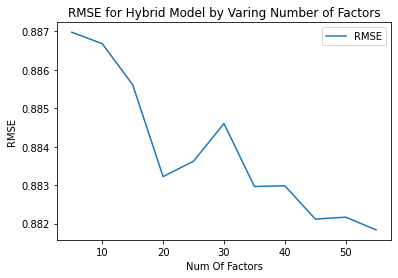

In [82]:
X=[]
rmse=[]
for i in range(5,60,5):
  param_grid = {'n_factors': [i], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
  gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
  gs.fit(data1)
  X.append(i)
  rmse.append(gs.best_score['rmse'])

fig, p = plt.subplots()
p.plot(X, rmse, label="RMSE")
p.set_xlabel("Num Of Factors")
p.set_ylabel("RMSE")
p.legend()
plt.title("RMSE for Hybrid Model by Varing Number of Factors")
plt.show()